<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Deep_Learning/blob/main/Seq2Seq_Encoder_Deocder_model_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

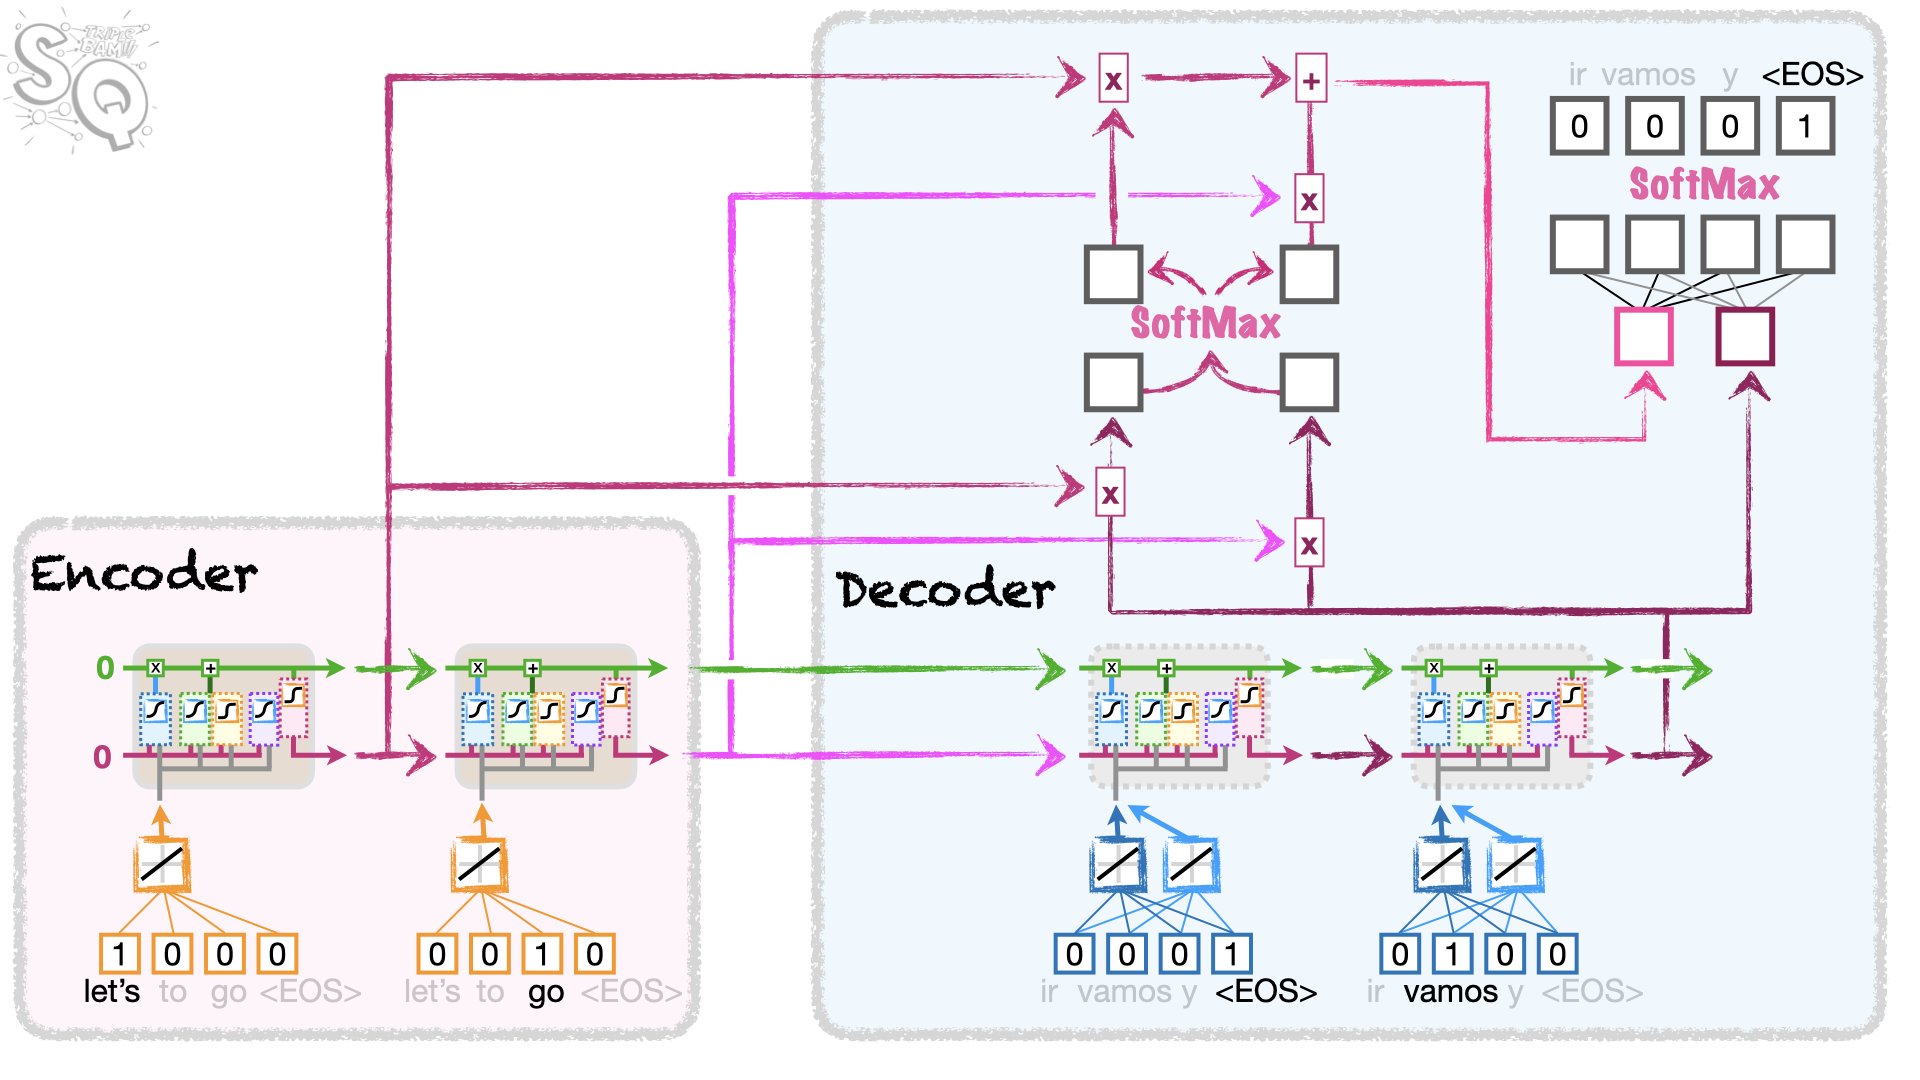

In [ ]:
import pip
try:
  __import__("lightning")
except ImportError:
  pip.main(['install', "lightning"])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import lightning as L


In [ ]:
english_token_to_id = {'lets': 0,
                       'to': 1,
                       'go': 2,
                       '<EOS>': 3 ## <EOS> = end of sequence
                      }

In [ ]:
english_id_to_token = dict(map(reversed, english_token_to_id.items()))

In [ ]:
spanish_token_to_id = {'ir': 0,
                       'vamos': 1,
                       'y': 2,
                       '<EOS>': 3}

In [ ]:
spanish_id_to_token = dict(map(reversed, spanish_token_to_id.items()))

In [ ]:
inputs = torch.tensor([[english_token_to_id["lets"],
                        english_token_to_id["go"]],

                       [english_token_to_id["to"],
                        english_token_to_id["go"]]])

In [ ]:
labels = torch.tensor([[spanish_token_to_id["vamos"],
                        spanish_token_to_id["<EOS>"]],

                       [spanish_token_to_id["ir"],
                        spanish_token_to_id["<EOS>"]]])

In [ ]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# Build and Train a Seq2Seq/Encoder-Decoder Model with Attention from Scratch

In [ ]:
class seq2seq_attention(L.LightningModule):

    def __init__(self, max_len=2):

        super().__init__()

        self.max_decoder_length = max_len

        L.seed_everything(seed=42)

        #################################
        ##
        ## ENCODING
        ##
        #################################
        self.encoder_we = nn.Embedding(num_embeddings=4, # num_embeddings = # of tokens in input vocabulary
                                       embedding_dim=1)  # embedding_dim = # of embedding values per token

        self.encoder_lstm = nn.LSTM(input_size=1, # encoder_size = number of inputs
                                    hidden_size=1,# hidden_size = number of outputs
                                    num_layers=1) # num_layers = how many lstm's to stack
                                                  #              If there are 2 layers, then the short term memory from the
                                                  #              first layer is used as input to the second layer

        #################################
        ##
        ## DECODING
        ##
        #################################
        self.decoder_we = nn.Embedding(num_embeddings=4,
                                       embedding_dim=1)

        self.decoder_lstm = nn.LSTM(input_size=1,
                                    hidden_size=1,
                                    num_layers=1)

        self.decoder_fc = nn.Linear(in_features=2,  # in_features = number of outputs per lstm * 2 (encoder + decoder)
                                   out_features=4) # out_features = number of words in the output vocabulary

        self.loss = nn.CrossEntropyLoss()


    def forward(self, input, output=None):

        # outputs = torch.zeros(self.max_decoder_length, 4)

        #################################
        ##
        ## ENCODING
        ##
        #################################
        ## first, use the encoder stage to create an intermediate encoding of the input text
        encoder_embeddings = self.encoder_we(input)
        encoder_lstm_output, (encoder_lstm_hidden, encoder_lstm_cell) = self.encoder_lstm(encoder_embeddings)

        #################################
        ##
        ## DECODING
        ##
        #################################
        ## We start by initializing the decoder with the <EOS> token...
        decoder_token_id = torch.tensor([spanish_token_to_id["<EOS>"]])
        decoder_embeddings = self.decoder_we(decoder_token_id)
        decoder_lstm_output, (decoder_lstm_hidden, decoder_lstm_cell) = self.decoder_lstm(decoder_embeddings,
                                                                                          (encoder_lstm_hidden,
                                                                                           encoder_lstm_cell))

        ## Calculate attention here (using unnormalized cosine similarity, aka, dot product, to score the alignment)
        ## In other words, we're trying to find words in the input that are used in the same context as those proposed
        ## by the lstm.
        sims = torch.matmul(decoder_lstm_output, encoder_lstm_output.transpose(dim0=0, dim1=1))
        ## Apply softmax to determine what percent of each token's value to
        ## use in the final attention values.
        attention_percents = F.softmax(sims, dim=1)

        ## Scale the values by their associated percentages and add them up.
        attention_values = torch.matmul(attention_percents, encoder_lstm_output)

        ## lastly, we need to concatenate the attention values with the short term
        ## memories from the first decoder lstm
        values_to_fc_layer = torch.cat((attention_values, decoder_lstm_output), 1)

        output_values = self.decoder_fc(values_to_fc_layer)
        outputs = output_values
        predicted_id = torch.tensor([torch.argmax(output_values)])
        predicted_ids = predicted_id

        for i in range(1, self.max_decoder_length):
            if (output == None): # using the model...
                if (predicted_id == spanish_token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
                    break
                decoder_embeddings = self.decoder_we(predicted_id)
            else:
                decoder_embeddings = self.decoder_we(torch.tensor([output[i-1]]))

            decoder_lstm_output, (decoder_lstm_hidden, decoder_lstm_cell) = self.decoder_lstm(decoder_embeddings,
                                                                                              (decoder_lstm_hidden,
                                                                                               decoder_lstm_cell))
            sims = torch.matmul(decoder_lstm_output, encoder_lstm_output.transpose(dim0=0, dim1=1))
            ## Apply softmax to determine what percent of each token's value to
            ## use in the final attention values.
            attention_percents = F.softmax(sims, dim=1)

            ## Scale the values by their associated percentages and add them up.
            attention_values = torch.matmul(attention_percents, encoder_lstm_output)

            values_to_fc_layer = torch.cat((attention_values, decoder_lstm_output), 1)

            output_values = self.decoder_fc(values_to_fc_layer)
            # outputs[i] = output_values
            outputs = torch. cat((outputs, output_values), 0)
            predicted_id = torch.tensor([torch.argmax(output_values)])
            predicted_ids = torch.cat((predicted_ids, predicted_id))

        return(outputs)


    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return Adam(self.parameters(), lr=0.1) ## NOTE: Setting the learning rate to 0.1 trains way faster than
                                               ## using the default learning rate, lr=0.001


    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0], labels[0]) # run input through the neural network
        loss = self.loss(output, labels[0]) ## self.loss = cross entropy
        ###################
        ##
        ## Logging the loss
        ##
        ###################
        # self.log("train_loss", loss)

        return loss

In [ ]:
model = seq2seq_attention()
outputs = model.forward(input=torch.tensor([english_token_to_id["lets"],
                                            english_token_to_id["go"]]), output=None)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

In [ ]:
trainer = L.Trainer(max_epochs=20, accelerator="cpu")
trainer.fit(model, train_dataloaders=dataloader)

In [ ]:
outputs = model.forward(input=torch.tensor([english_token_to_id["lets"],
                                            english_token_to_id["go"]]), ## translate "lets go", we should get "vamos <EOS>"
                        output=None)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

In [ ]:
outputs = model.forward(input=torch.tensor([english_token_to_id["to"],
                                            english_token_to_id["go"]]), ## translate "to go", we should get "ir <EOS>"
                        output=None)

print("Translated text:")
predicted_ids = torch.argmax(outputs, dim=1)
for id in predicted_ids:
    print("\t", spanish_id_to_token[id.item()])

In [ ]:
print("After optimization, the parameters are...")
for name, param in model.named_parameters():
    print(name, param.data)